This is automated script to perform necessary headline collection, function call to get tweeter feedback and perform final calcualation. company_name_list contains company name ( must be same as source website name like finvix.com)

In [1]:
# URL link for headline related to TESLA in FinViz
finviz_link = 'https://finviz.com/quote.ashx?t='
# information related to my OS and browser that I have to send to remote server
user_agent = 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'

#Related library to process collected data
from urllib.request import urlopen, Request
from bs4 import  BeautifulSoup
import os
# import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tweet_sentiment import twitter_sentimant

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Tesla , Amazon, Google, Apple
company_name_list = ['TSLA','AMZN','GOOG','AAPL','META','NFLX','AMD','INTC','NVDA']
# company_name_list = ['META']
news_dictionary = {}

#collect new related to each companies

for company_name in company_name_list:
    url = finviz_link + company_name
    req = Request(url=url,headers={'User-Agent':user_agent})
    response = urlopen(req)
    html = BeautifulSoup(response)
    news_list = html.find(id='news-table')
    # print(news_list)
    news_dictionary[company_name] = news_list
    continue

In [3]:
# We create initial list of the collected news
parsed_data =[]
prev_date=None # To avoid extreme case related error if first news does not contain any date
for company_name,news_list in news_dictionary.items():
    company = company_name.split('_')[0]
    for news in news_list.findAll('tr'):
        # here we will collct the headline as text and sparse date and time
        if(news.a == None):
            continue
        headline = news.a.get_text()
        date_and_time = news.td.get_text().split(' ')
        if len(date_and_time) == 1 :
            date = prev_date # we assume it's colse to previous headline date
            time = date_and_time[0]
        else:
            date = date_and_time[0]
            time = date_and_time[1]
        parsed_data.append([company,date,time,headline])
# Create a panda dataframe
columns = ['company','date','time','headline']
parsed_data = pd.DataFrame(parsed_data, columns=columns)

In [4]:
parsed_data.to_csv('Nov30_headline.csv')

In [5]:
#using vader to generate polarity score  from headline
vader = SentimentIntensityAnalyzer()
vader_score = parsed_data['headline'].apply(vader.polarity_scores).tolist()
score_df = pd.DataFrame(vader_score)
# score_df

In [6]:
parsed_data_and_score = parsed_data.join(score_df,rsuffix='_right')
# parsed_data_and_score

In [7]:
#  Add tweeter sentiment feedback
t_vader = twitter_sentimant(parsed_data['headline'].tolist())

# t_vader

In [8]:
# for headline in parsed_data['headline']:
#     print(headline)
lambda_factor=[0,0.25,0.5,0.75,1]
t_score_df = pd.DataFrame(t_vader)


In [9]:
result_df = parsed_data_and_score[['company','date','headline','compound']].copy()
result_df.rename(columns={'compound':'h_sentiment'},inplace=True)
t_score_df.rename(columns={'compound':'t_sentiment'},inplace=True)
result_df = result_df.join(t_score_df['t_sentiment'],rsuffix='_right')
lambda_df = pd.DataFrame()
for lambda_val in lambda_factor:
    name= str(lambda_val)+'_labda'
    lambda_df[name]=result_df['h_sentiment']*(1-lambda_val)+result_df['t_sentiment']*lambda_val
result_df = result_df.join(lambda_df,rsuffix='_right')
result_df       # This data frame contains all the result

,company,date,headline,h_sentiment,t_sentiment,0_labda,0.25_labda,0.5_labda,0.75_labda,1_labda
0,TSLA,Nov-30-22,Elon Musk and Apple's Tim Cook Make Peace,0.5423,-0.052670,0.5423,0.393558,0.244815,0.096073,-0.052670
1,TSLA,None,S&P 500 Surges Above Key Level On Fed Chief Po...,-0.3291,-0.244036,-0.3291,-0.307834,-0.286568,-0.265302,-0.244036
2,TSLA,None,Elon Musk says Apple never considered removing...,0.0000,-0.195144,0.0000,-0.048786,-0.097572,-0.146358,-0.195144
3,TSLA,None,US STOCKS-Wall Street ends sharply higher afte...,0.0000,-0.127893,0.0000,-0.031973,-0.063946,-0.095920,-0.127893
4,TSLA,None,"Tesla Stock Vs. BYD Stock: EV Giants Soar, But...",0.0000,1.000000,0.0000,0.250000,0.500000,0.750000,1.000000
...,...,...,...,...,...,...,...,...,...,...
895,NVDA,None,Nvidia Third-Quarter Earnings Live Blog,0.0000,1.000000,0.0000,0.250000,0.500000,0.750000,1.000000
896,NVDA,None,Why Nvidia Shares Fell Ahead of Earnings Today,0.2960,0.287075,0.2960,0.293769,0.291538,0.289307,0.287075
897,NVDA,None,"Nvidia, Microsoft to Join Forces on 'Supercomp...",0.2960,0.344141,0.2960,0.308035,0.320071,0.332106,0.344141
898,NVDA,None,When to Buy Micron Stock Despite Bearish Update,0.0000,0.055023,0.0000,0.013756,0.027512,0.041268,0.055023


C:\Users\shaik\AppData\Local\Temp\ipykernel_29220\3827840738.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = result_df.groupby(['company','date']).mean()


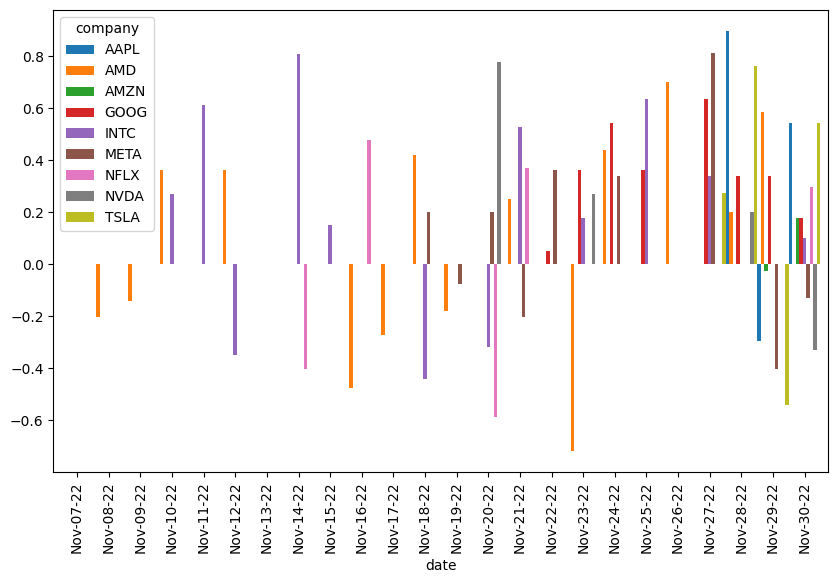

In [10]:
#plot data without tweeter feedback
plt.rcParams['figure.figsize']=[10,6]
mean_scores = result_df.groupby(['company','date']).mean()
mean_scores =mean_scores.unstack().xs('h_sentiment',axis="columns").transpose()
mean_scores.plot(kind='bar',stacked=False,width=1)

plt.show()


C:\Users\shaik\AppData\Local\Temp\ipykernel_29220\1538175913.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = result_df.groupby(['company','date']).mean()


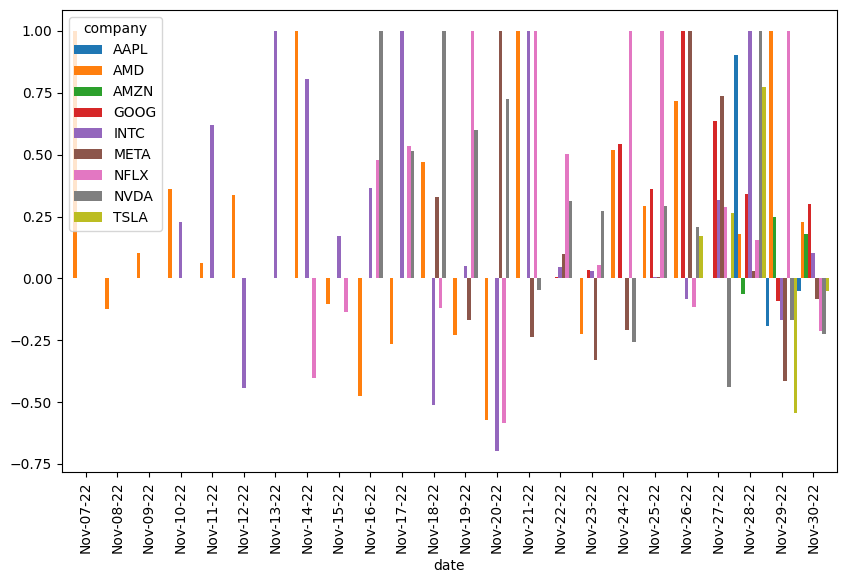

In [11]:
#plot data without tweeter feedback
plt.rcParams['figure.figsize']=[10,6]
mean_scores = result_df.groupby(['company','date']).mean()
mean_scores =mean_scores.unstack().xs('t_sentiment',axis="columns").transpose()
mean_scores.plot(kind='bar',stacked=False,width=1)

plt.show()


In [12]:
mean_scores

company,AAPL,AMD,AMZN,GOOG,INTC,META,NFLX,NVDA,TSLA
date,,,,,,,,,
Nov-07-22,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nov-08-22,NaN,-0.121925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nov-09-22,NaN,0.100867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nov-10-22,NaN,0.361200,NaN,NaN,0.226980,NaN,NaN,NaN,NaN
Nov-11-22,NaN,0.063796,NaN,NaN,0.620969,NaN,NaN,NaN,NaN
Nov-12-22,NaN,0.335148,NaN,NaN,-0.443563,NaN,NaN,NaN,NaN
Nov-13-22,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
Nov-14-22,NaN,1.000000,NaN,NaN,0.807400,NaN,-0.401900,NaN,NaN
Nov-15-22,NaN,-0.102289,NaN,NaN,0.171777,NaN,-0.136105,NaN,NaN


In [13]:
result_df.to_csv('sentiment_data.csv')